(481, 23)
                                      title  vote_count  vote_average  \
0                                    Avatar       11800           7.2   
1  Pirates of the Caribbean: At World's End        4500           6.9   
2                                   Spectre        4466           6.3   
3                     The Dark Knight Rises        9106           7.6   
4                               John Carter        2124           6.1   
5                              Spider-Man 3        3576           5.9   
6                                   Tangled        3330           7.4   
7                   Avengers: Age of Ultron        6767           7.3   
8    Harry Potter and the Half-Blood Prince        5293           7.4   
9        Batman v Superman: Dawn of Justice        7004           5.7   

      score  
0  7.050669  
1  6.665696  
2  6.239396  
3  7.346721  
4  6.096368  
5  5.965250  
6  6.934805  
7  7.041968  
8  7.062856  
9  5.781535  


Text(0.5, 1.0, 'popular movies')

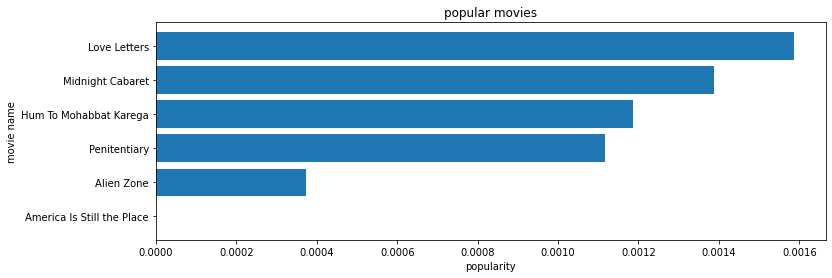

In [1]:
import numpy as np
import pandas as pd
df1=pd.read_csv('C:/Users/kushal asn/Desktop/movie_recommender/tmdb_5000/tmdb_5000_credits.csv')
df2=pd.read_csv('C:/Users/kushal asn/Desktop/movie_recommender/tmdb_5000/tmdb_5000_movies.csv')

df1.columns=['id','tittle','cast','crew']
df2=df2.merge(df1,on='id')


c=df2['vote_average'].mean()


m=df2['vote_count'].quantile(0.9)

q_movies=df2.copy().loc[df2['vote_count']>=m]
print(q_movies.shape)

def weighted_rating(df2,m=m,c=c):
    v=df2['vote_count']
    R=df2['vote_average']
    return (v/(v+m)* R) + (m/(m+v)*c)


q_movies['score']=q_movies.apply(weighted_rating,axis=1) 
q_movies.sort_values('score',ascending=False)
print(q_movies[['title','vote_count','vote_average','score']].head(10))   


pop=df2.sort_values('popularity')
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.barh(pop['title'].head(6),pop['popularity'].head(6))
plt.xlabel("popularity")
plt.ylabel("movie name")
plt.title("popular movies")

In [2]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(stop_words='english')
df2['overview']=df2['overview'].fillna('')
tfidf_matrix=tfidf.fit_transform(df2['overview'])
tfidf_matrix.shape

(4803, 20978)

In [4]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim=linear_kernel(tfidf_matrix,tfidf_matrix)

In [5]:
indices=pd.Series(df2.index,index=df2['title']).drop_duplicates()

In [6]:
def get_recommendations(title,cosine_sim=cosine_sim):
    idx=indices[title]
    sim_scores=list(enumerate(cosine_sim[idx]))
    sim_scores=sorted(sim_scores,key=lambda x: x[1],reverse=True)
    sim_scores=sim_scores[1:11]
    movie_indices=[i[0] for i in sim_scores]
   
    return df2['title'].iloc[movie_indices]
     




In [7]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [8]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

In [9]:
from ast import literal_eval
features=['cast','crew','keywords','genres']
for feature in features:
    df2[feature]=df2[feature].apply(literal_eval)

In [10]:
def get_director(x):
    for i in x:
        if i['job']=='Director':
            return i['name']
        
    return np.nan    
            

In [11]:
def get_list(x):
    if isinstance(x,list):
        names=[i['name'] for i in x]
        if len(names)>3:
            names=names[:3]
        return names
    
    return []
       

In [12]:
df2['director']=df2['crew'].apply(get_director)
features=['cast','keywords','genres']
for feature in features:
    df2[feature]=df2[feature].apply(get_list)

In [13]:
df2[['title','cast','director','keywords','genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [14]:
def clean_data(x):
    if isinstance(x,list):
        return [str.lower(i.replace(" ","")) for i in x]
    else:
        if isinstance(x,str):
            return str.lower(x.replace(" ",""))
        else:
            return ''

In [15]:
features=['cast','keywords','director','genres']
for feature in features:
    df2[feature]=df2[feature].apply(clean_data)

In [16]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count=CountVectorizer(stop_words='english')
count_matrix=count.fit_transform(df2['soup'])

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2=cosine_similarity(count_matrix,count_matrix)

In [19]:
df2=df2.reset_index()
indices=pd.Series(df2.index,index=df2['title'])

In [20]:
get_recommendations('The Dark Knight Rises',cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [21]:
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate
reader=Reader()
ratings=pd.read_csv('C:/Users/kushal asn/Desktop/movie_recommender/movies_dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [22]:
data=Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)


In [23]:
algo=SVD()
cross_validate(algo,data,measures=['RMSE','MAE'],cv=5,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8987  0.8947  0.8972  0.8955  0.9007  0.8974  0.0022  
MAE (testset)     0.6889  0.6901  0.6909  0.6890  0.6951  0.6908  0.0023  
Fit time          6.15    5.76    5.78    7.21    5.91    6.16    0.54    
Test time         0.16    0.14    0.15    0.17    0.21    0.17    0.02    


{'test_rmse': array([0.89873436, 0.89469651, 0.89724818, 0.89545943, 0.90071122]),
 'test_mae': array([0.68894478, 0.69005281, 0.69094238, 0.6890338 , 0.69512221]),
 'fit_time': (6.153234004974365,
  5.763387203216553,
  5.777778625488281,
  7.206932067871094,
  5.908466577529907),
 'test_time': (0.1612403392791748,
  0.143721342086792,
  0.14740777015686035,
  0.16573524475097656,
  0.20694494247436523)}

In [24]:
trainset=data.build_full_trainset()
algo.fit(trainset)

In [25]:
ratings[ratings['userId']==1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [26]:
algo.predict(1,302,3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8410967856754947, details={'was_impossible': False})